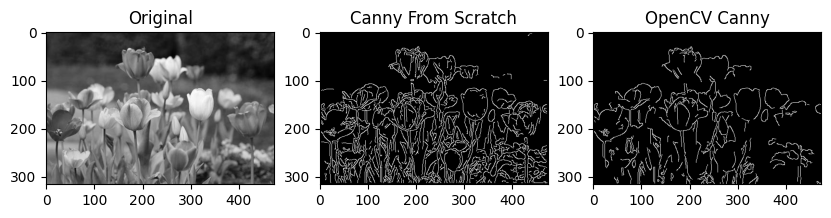

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


# -----------------------------
# 1. Gaussian Kernel
# -----------------------------
def gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)


# -----------------------------
# 2. Convolution
# -----------------------------
def convolve(image, kernel):
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2

    padded = np.pad(image, ((pad_h, pad_h), (pad_w, pad_w)), mode='constant')
    output = np.zeros_like(image)

    for i in range(image_h):
        for j in range(image_w):
            region = padded[i:i+kernel_h, j:j+kernel_w]
            output[i, j] = np.sum(region * kernel)

    return output


# -----------------------------
# 3. Sobel Gradient
# -----------------------------
def sobel_filters(image):
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])

    Ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]])

    Ix = convolve(image, Kx)
    Iy = convolve(image, Ky)

    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return G, theta


# -----------------------------
# 4. Non-Maximum Suppression
# -----------------------------
def non_max_suppression(G, theta):
    H, W = G.shape
    output = np.zeros((H, W))
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, H-1):
        for j in range(1, W-1):
            q = 255
            r = 255

            # 0 degrees
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = G[i, j+1]
                r = G[i, j-1]

            # 45 degrees
            elif (22.5 <= angle[i,j] < 67.5):
                q = G[i+1, j-1]
                r = G[i-1, j+1]

            # 90 degrees
            elif (67.5 <= angle[i,j] < 112.5):
                q = G[i+1, j]
                r = G[i-1, j]

            # 135 degrees
            elif (112.5 <= angle[i,j] < 157.5):
                q = G[i-1, j-1]
                r = G[i+1, j+1]

            if (G[i,j] >= q) and (G[i,j] >= r):
                output[i,j] = G[i,j]
            else:
                output[i,j] = 0

    return output


# -----------------------------
# 5. Double Threshold
# -----------------------------
def double_threshold(image, low, high):
    result = np.zeros_like(image)
    strong = 255
    weak = 75

    strong_i, strong_j = np.where(image >= high)
    weak_i, weak_j = np.where((image <= high) & (image >= low))

    result[strong_i, strong_j] = strong
    result[weak_i, weak_j] = weak

    return result, weak, strong

# -----------------------------
# 6. Hysteresis
# -----------------------------
def hysteresis(image, weak, strong=255):
    H, W = image.shape

    for i in range(1, H-1):
        for j in range(1, W-1):
            if image[i,j] == weak:
                if ((image[i+1, j-1] == strong) or
                    (image[i+1, j] == strong) or
                    (image[i+1, j+1] == strong) or
                    (image[i, j-1] == strong) or
                    (image[i, j+1] == strong) or
                    (image[i-1, j-1] == strong) or
                    (image[i-1, j] == strong) or
                    (image[i-1, j+1] == strong)):
                    image[i,j] = strong
                else:
                    image[i,j] = 0
    return image


# -----------------------------
# Complete Canny Pipeline
# -----------------------------
def canny_from_scratch(image, kernel_size=5, sigma=1, low=100, high=200):

    kernel = gaussian_kernel(kernel_size, sigma)
    blurred = convolve(image.astype(np.float32), kernel)

    G, theta = sobel_filters(blurred)

    nms = non_max_suppression(G, theta)

    # ✅ Correct call (NO named parameters)
    dt, weak, strong = double_threshold(nms, low, high)

    final = hysteresis(dt, weak, strong)

    return final


# -----------------------------
# Run Example
# -----------------------------
list_path = os.getcwd().split(os.sep)
list_path.pop()
list_path.pop()
list_path.append('images')
image_path = os.sep.join(list_path) + os.sep + 'tulip.jpeg'

image = cv2.imread(image_path, 0)

edges = canny_from_scratch(image, kernel_size=3, sigma=1, low=10, high=20)
canny = cv2.Canny(image, 100, 200,L2gradient=True)
plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(image, cmap='gray')

plt.subplot(1,3,2)
plt.title("Canny From Scratch")
plt.imshow(edges, cmap='gray')

plt.subplot(1,3,3)
plt.title("OpenCV Canny")
plt.imshow(canny, cmap='gray')
plt.show()